In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
def generate_data(num_sequences, min_length, max_length):
    sequences = []
    counts = []
    lengths = []
    for _ in range(num_sequences):
        length = np.random.randint(min_length, max_length + 1)
        sequence = np.random.randint(0, 2, length).tolist()
        count_ones = sum(sequence)
        sequences.append(sequence)
        counts.append(count_ones)
        lengths.append(length)
    return sequences, counts, lengths

# Hyperparameters
NUM_SEQUENCES = 10000
MIN_LENGTH = 1
MAX_LENGTH = 16
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Generate the dataset
sequences, counts, lengths = generate_data(NUM_SEQUENCES, MIN_LENGTH, MAX_LENGTH)
train_seqs, temp_seqs, train_counts, temp_counts, train_lengths, temp_lengths = train_test_split(
    sequences, counts, lengths, test_size=VAL_RATIO + TEST_RATIO, random_state=42
)

val_seqs, test_seqs, val_counts, test_counts, val_lengths, test_lengths = train_test_split(
    temp_seqs, temp_counts, temp_lengths, test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO), random_state=42
)

print(f"Train set: {len(train_seqs)} samples")
print(f"Validation set: {len(val_seqs)} samples")
print(f"Test set: {len(test_seqs)} samples")


Train set: 6999 samples
Validation set: 2000 samples
Test set: 1001 samples


In [46]:
print("Seqs:")
print(train_seqs[:5])
print("Labels:")
print(train_counts[:5])
print(train_lengths[:5])


Seqs:
[[1, 1, 1, 0, 0, 1], [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0], [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]]
Labels:
[4, 9, 5, 6, 5]
[6, 16, 14, 15, 13]


In [56]:
# def pad_sequences(sequences, max_length):
#     padded = np.zeros((len(sequences), max_length))
#     for i, seq in enumerate(sequences):
#         padded[i, :len(seq)] = seq
#     return padded

# # Find the maximum sequence length for padding
# max_length = max([len(seq) for seq in sequences])

# # # Padding sequences
# train_seqs = pad_sequences(train_seqs, max_length)
# val_seqs = pad_sequences(val_seqs, max_length)
# test_seqs = pad_sequences(test_seqs, max_length)
# def collate_fn(batch):
#     sequences, counts = zip(*batch)
#     lengths = [len(seq) for seq in sequences]
#     max_length = max(lengths)
#     padded_sequences = pad_sequences(sequences, max_length)
#     return torch.tensor(padded_sequences, dtype=torch.float32), torch.tensor(counts, dtype=torch.float32)

# Convert to PyTorch tensors
class BitSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

train_dataset = BitSequenceDataset(train_seqs, train_counts)
val_dataset = BitSequenceDataset(val_seqs, val_counts)
test_dataset = BitSequenceDataset(test_seqs, test_counts)

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [58]:
import torch.nn as nn

class BitCounterRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, dropout=0.3):
        super(BitCounterRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        output, hidden = self.rnn(x)
        last_output = output[:, -1, :]  # Get the last output state
        # Apply batch normalization
        # last_output = self.batch_norm(last_output)
        count_output = self.fc(last_output).squeeze(-1)
        return count_output
# Model Hyperparameters
# Model Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 2
dropout = 0.3
# Initialize the BitCounterRNN model
model = BitCounterRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (MAE)
optimizer = optim.Adam(model.parameters(), lr=0.00001)



In [60]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         train_loss = 0
#         for sequences, labels in train_loader:
#             device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#             sequences, labels = sequences.to(device), labels.to(device)
#             optimizer.zero_grad()
#             predictions = model(sequences)
#             loss = criterion(predictions, counts)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         # Validation
#         model.eval()
#         val_loss = 0
#         val_mae = 0
#         with torch.no_grad():
#             for sequences, counts in val_loader:
#                 predictions = model(sequences)
#                 loss = criterion(predictions, counts)
#                 val_loss += loss.item()

#                 # Calculate MAE
#                 mae = nn.L1Loss()(predictions, counts)
#                 val_mae += mae.item()

#         train_loss /= len(train_loader)
#         val_loss /= len(val_loader)
#         val_mae /= len(val_loader)

#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Training on {device}.")

    model.to(device)

    for epoch in range(epochs):
        # Training loop
        model.train()
        running_loss = 0.0
        correct_pred = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(sequences)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * sequences.size(0)

            # Calculate the number of correct predictions
            correct_pred += torch.sum(torch.round(outputs) == labels).item()

        # Calculate the average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_pred / len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_pred = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)

                # Forward pass
                outputs = model(sequences)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * sequences.size(0)

                # Calculate the number of correct predictions
                val_correct_pred += torch.sum(torch.round(outputs) == labels).item()

        # Calculate the average validation loss and MAE
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct_pred / len(val_loader.dataset)

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    return model

num_epochs = 10
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Training on cuda.
Epoch 1/10, Train Loss: 0.5406
Epoch 2/10, Train Loss: 0.4612
Epoch 3/10, Train Loss: 0.4075
Epoch 4/10, Train Loss: 0.3657
Epoch 5/10, Train Loss: 0.3380
Epoch 6/10, Train Loss: 0.3139
Epoch 7/10, Train Loss: 0.2928
Epoch 8/10, Train Loss: 0.2781
Epoch 9/10, Train Loss: 0.2615
Epoch 10/10, Train Loss: 0.2466
Train Accuracy: 0.8998
Validation Accuracy: 0.9515


In [63]:
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)  # Move model to the correct device (GPU or CPU)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for sequences, counts in test_loader:
            # Move input data to the same device as the model
            sequences, counts = sequences.to(device), counts.to(device)

            # Get predictions
            predictions = model(sequences)

            # Compute loss
            loss = criterion(predictions, counts)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f"Test Loss (MAE): {test_loss:.4f}")

# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_model(model, test_loader, criterion, device)


Test Loss (MAE): 0.1533


In [68]:
def random_baseline(test_counts):
    # Convert the basic list to a PyTorch tensor
    test_counts_tensor = torch.tensor(test_counts, dtype=torch.float32)

    # Get the minimum and maximum count values
    min_count = int(min(test_counts_tensor).item())
    max_count = int(max(test_counts_tensor).item())

    # Create random baseline predictions in the range [min_count, max_count]
    baseline_predictions = torch.randint(min_count, max_count + 1, test_counts_tensor.size(), dtype=torch.float32)

    # Compute the Mean Absolute Error (MAE)
    mae = nn.L1Loss()(baseline_predictions, test_counts_tensor)
    print(f"Random Baseline MAE: {mae:.4f}")



# Compare with random baseline
random_baseline(test_counts)


Random Baseline MAE: 4.0649


In [72]:
def predict_samples(model, sequences, counts, num_samples=5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)  # Move model to the correct device

    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            # Select the sequence from the list
            input_seq = sequences[i]
            true_count = counts[i]

            # Convert input sequence to a tensor and move it to the same device as the model
            input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to device

            # Get model prediction
            predicted_count = model(input_seq_tensor).item()

            # Print the input sequence, true count, and predicted count
            input_str = ''.join(map(str, input_seq))  # Convert to string for easy printing
            print(f"Sequence: {input_str}")
            print(f"True Count of '1's: {true_count}")
            print(f"Predicted Count of '1's: {predicted_count:.2f}")
            print("-" * 50)


predict_samples(model, test_seqs, test_counts, num_samples=5)


Sequence: 01111111011010
True Count of '1's: 10
Predicted Count of '1's: 9.07
--------------------------------------------------
Sequence: 0100011000010100
True Count of '1's: 5
Predicted Count of '1's: 5.01
--------------------------------------------------
Sequence: 01011
True Count of '1's: 3
Predicted Count of '1's: 3.00
--------------------------------------------------
Sequence: 1110011
True Count of '1's: 5
Predicted Count of '1's: 4.94
--------------------------------------------------
Sequence: 1010111110110100
True Count of '1's: 10
Predicted Count of '1's: 9.11
--------------------------------------------------


In [73]:
def generate_ood_data(num_sequences=1000, min_length=1, max_length=32):
    sequences = []
    counts = []
    lengths = []
    for _ in range(num_sequences):
        length = np.random.randint(min_length, max_length + 1)
        sequence = np.random.randint(0, 2, length).tolist()
        count_ones = sum(sequence)
        sequences.append(sequence)
        counts.append(count_ones)
        lengths.append(length)
    return sequences, counts, lengths

# Generate OOD data with sequence lengths from 1 to 32
ood_sequences, ood_counts, ood_lengths = generate_ood_data(num_sequences=1000, min_length=1, max_length=32)


In [75]:
import torch
import numpy as np

def evaluate_ood_model(model, sequences, counts, lengths, device):
    mae_per_length = {length: [] for length in range(1, 33)}  # Store MAE for each sequence length

    model.to(device)  # Ensure the model is on the correct device
    model.eval()

    with torch.no_grad():
        for seq, count, length in zip(sequences, counts, lengths):
            input_seq = torch.tensor(seq).unsqueeze(0).float().to(device)  # Move input_seq to the correct device
            true_count = torch.tensor(count).float().to(device)  # Move true_count to the correct device
            predicted_count = model(input_seq).float()

            mae = abs(predicted_count - true_count).item()
            mae_per_length[length].append(mae)

    # Calculate average MAE for each sequence length
    avg_mae_per_length = {length: np.mean(mae_per_length[length]) for length in mae_per_length}
    return avg_mae_per_length

# Evaluate the model on OOD data for sequences from 1 to 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mae_per_length = evaluate_ood_model(model, ood_sequences, ood_counts, ood_lengths, device)


MAE for 1 : 0.06789332109948863
MAE for 2 : 0.10559158855014378
MAE for 3 : 0.0747309614110876
MAE for 4 : 0.05130770188920638
MAE for 5 : 0.0453101108814108
MAE for 6 : 0.038671918489314894
MAE for 7 : 0.04176953504251879
MAE for 8 : 0.05908913381638065
MAE for 9 : 0.07266819477081299
MAE for 10 : 0.09784564827427719
MAE for 11 : 0.12768086310355894
MAE for 12 : 0.16045532101079038
MAE for 13 : 0.24593603199925915
MAE for 14 : 0.2848481759428978
MAE for 15 : 0.3489841034537868
MAE for 16 : 0.44641300042470294
MAE for 17 : 0.6359830452845647
MAE for 18 : 1.0406629592180252
MAE for 19 : 0.8134410564716046
MAE for 20 : 1.2991863985856373
MAE for 21 : 1.677667524503625
MAE for 22 : 1.9556907127643455
MAE for 23 : 1.8833245573372677
MAE for 24 : 2.5730552351152576
MAE for 25 : 2.9009638199439416
MAE for 26 : 3.10940404560255
MAE for 27 : 3.2857285290956497
MAE for 28 : 4.311387957948627
MAE for 29 : 4.154686553137643
MAE for 30 : 4.650559569850112
MAE for 31 : 5.000034173329671
MAE for 32 

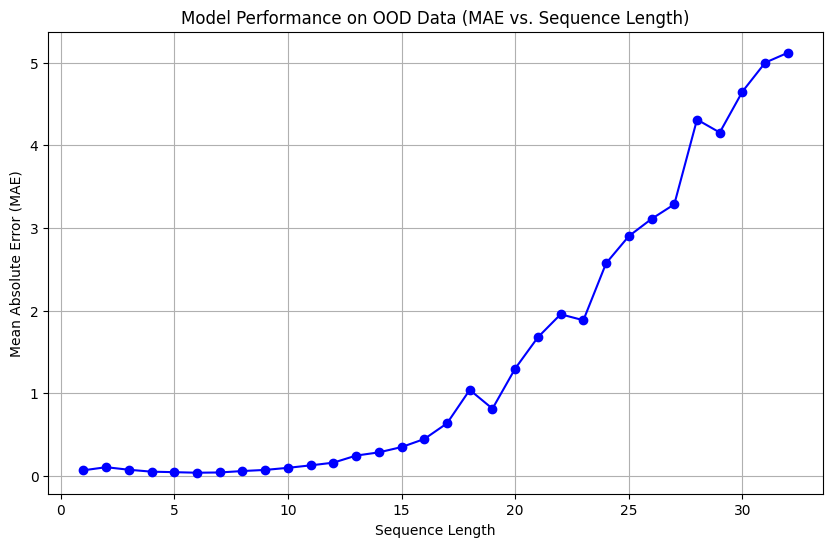

In [77]:
import matplotlib.pyplot as plt
for i in mae_per_length:
  print("MAE for",i,":",mae_per_length[i])
# Plotting the results
sequence_lengths = list(mae_per_length.keys())
mae_values = list(mae_per_length.values())

plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, mae_values, marker='o', linestyle='-', color='b')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance on OOD Data (MAE vs. Sequence Length)')
plt.grid(True)
plt.show()
